# Monte Carlo Simulations for wind and solar energy generation

This script performs Monte Carlo simulations to generate wind energy scenarios.

In this phase, we focus on generating three wind energy scenarios from SMOPF data for a selected zone (Zone 4):
1. Stormy: High wind generation with variability.
2. Blue-sky: Low wind generation.
3. Cloudy: Moderate wind generation.

For each scenario, we calculate an average power value for each time slot and store them deterministically for optimization.
This data preparation is a crucial step before actual optimization, ensuring deterministic inputs derived from stochastic processes.
Solar scenarios will be adressed later.

## Simulating wind power generation

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load SMOPF .out file for Zone 4 (CSV-like structure with headers)
zone_file = 'scen_zone4.out'
with open(zone_file, 'r') as f:
    lines = f.readlines()

# Parse .out file, skipping non-numeric characters and cleaning data
columns = lines[0].strip().replace('"', '').split(',')  # Extract column names
values = []
for line in lines[1:]:
    cleaned = [val.strip().replace('"', '') for val in line.strip().split(',')]
    if all(v.replace('.', '', 1).isdigit() for v in cleaned if v):  # Only append numeric rows
        values.append(cleaned)

# Convert parsed values into a DataFrame with numeric types
df = pd.DataFrame(values, columns=columns).apply(pd.to_numeric, errors='coerce').dropna()


In [3]:
df.head()

,,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100
0,1,0.202066,0.618855,0.369492,0.554819,0.304464,0.372905,0.428360,0.304673,0.360802,...,0.478156,0.433990,0.531460,0.441590,0.213892,0.331713,0.622544,0.422731,0.570265,0.497731
1,2,0.314266,0.572205,0.413033,0.645121,0.323205,0.444086,0.469651,0.369770,0.314599,...,0.514702,0.469606,0.611188,0.576327,0.260173,0.392204,0.587528,0.429621,0.626956,0.597842
2,3,0.432348,0.567021,0.531892,0.738136,0.443867,0.520497,0.575438,0.525311,0.487302,...,0.560705,0.540094,0.707794,0.639118,0.431890,0.538462,0.558388,0.475156,0.755811,0.693867
3,4,0.452174,0.597090,0.604010,0.685406,0.398851,0.553312,0.649824,0.609127,0.510512,...,0.635438,0.637945,0.704814,0.729506,0.427900,0.616431,0.643202,0.588758,0.809137,0.774059
4,5,0.584758,0.716445,0.565540,0.781534,0.571023,0.600808,0.645822,0.690471,0.661434,...,0.671555,0.720452,0.708315,0.751806,0.530302,0.652325,0.647131,0.614405,0.769688,0.791011


In [4]:
# Monte Carlo simulation setup
np.random.seed(42)                 # A random seed is set for reproductability
scenarios = {}

# Generate scenario variations with Gaussian noise
def create_scenario(base, scenario_type):             # three scenarios are created and stored in a dictionary
    noise_dict = {
        'stormy': (1.2, 0.1),   # High wind intensity
        'blue_sky': (0.5, 0.1), # Low wind intensity
        'cloudy': (0.7, 0.1)    # Moderate wind intensity
    }
    scale, stddev = noise_dict.get(scenario_type, (1.0, 0.0))
    return base * np.random.normal(scale, stddev, len(base))

# Create scenarios for each type
for scenario_type in ['stormy', 'blue_sky', 'cloudy']:
    scenarios[scenario_type] = create_scenario(df.iloc[:, 1].values, scenario_type)


In [5]:
# Calculate and store average power values per scenario
scenario_df = pd.DataFrame({'time': df.iloc[:, 0]})
for scenario_type, values in scenarios.items():
    scenario_df[scenario_type] = np.mean(values.reshape(-1, 1), axis=1)

In [ ]:
# Save averaged scenario outputs to CSV
scenario_df.to_csv('wind_scenarios.csv', index=False)
print("Wind scenarios saved to '/mnt/data/wind_scenarios.csv'")

Wind scenarios saved to '/mnt/data/wind_scenarios.csv'


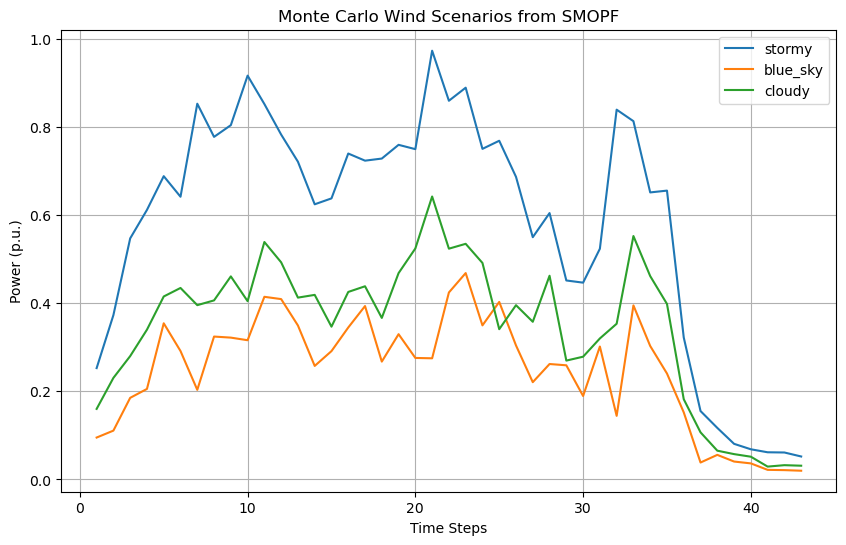

In [6]:
# Plot all generated scenarios
plt.figure(figsize=(10, 6))
for scenario_type, values in scenarios.items():
    plt.plot(scenario_df['time'], values, label=scenario_type)
plt.xlabel('Time Steps')
plt.ylabel('Power (p.u.)')
plt.title('Monte Carlo Wind Scenarios from SMOPF')
plt.legend()
plt.grid(True)
plt.show()